# Long-lived RecB spots

In [1]:
from pyberries.data import DatasetPool

data = (DatasetPool(path='D:\\DanielThedie\\BACMMAN\\Timelapse',
                    dsList=['230725_1', '230725_2', '230126_DT23', '230719_1', '230719_2',
                            '230817_1', '230810_1', '230816_1',
                            '230906_2', '230912_1', '230912_2',
                            '230907_1', '230907_2', '230913_1',
                            '230118_DT23', '230720_1', '230720_2', '230726_cipro30', '230824_1', '230829_1', '230201_DT23', '230504_2sec', '230718_2sec'
                            ],
                    groups=['0', '0', '0', '0', '0', 
                            '3 ng/mL', '3 ng/mL', '3 ng/mL',
                            '10 ng/mL', '10 ng/mL', '10 ng/mL',
                            '20 ng/mL', '20 ng/mL', '20 ng/mL',
                            '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL', '30 ng/mL'
                            ],
                    metadata={'all':'DateTime'},
                    filters={'all':'Frame < 50'},
                    rename_objects={'Spot_detection':'RecB_spots'},
                    rename_cols={'SpotCount':'RecBSpotCount'}
                    )
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        )

Dataset 230725_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230725_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230126_DT23: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230719_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw']
Dataset 230817_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230810_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230816_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230906_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230912_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230912_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', 'RecB_raw']
Dataset 230907_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecA', '

In [ ]:
data.describe()

## JF549 bleaching rates

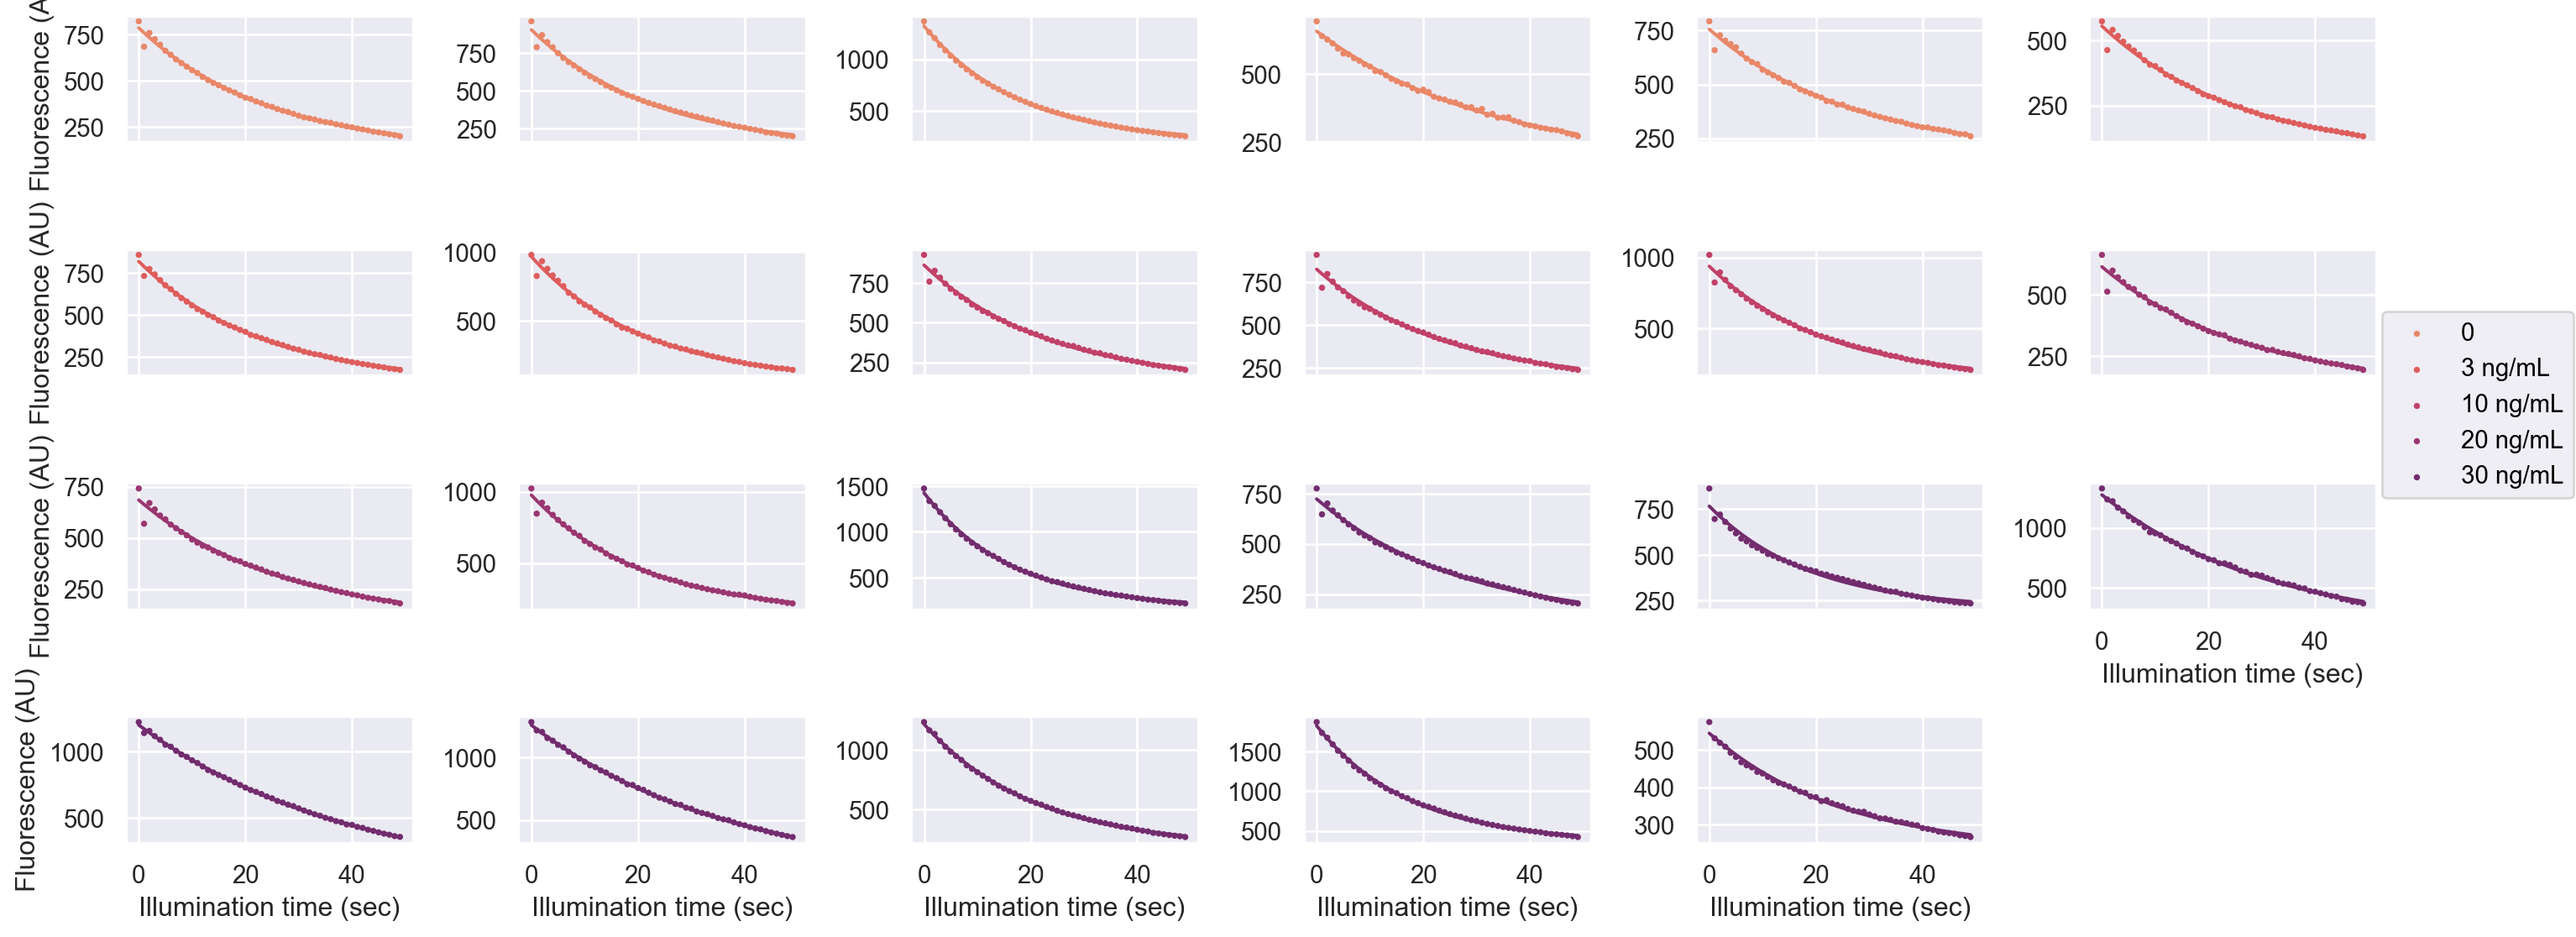

In [2]:
from pyberries.data import Fit
import seaborn.objects as so

bleaching_fit = Fit(data.Bacteria_large, x='Frame', y='SNR',
                    groupby=['Group', 'Dataset'], model_type='monoexp_decay_offset',
                    p0=[data.Bacteria_large.SNR.iloc[0], 1, 0])

(
    so.Plot(bleaching_fit.data, x='Frame', color='Group')
    .layout(size=(15, 6))
    .facet(col='Dataset', wrap=6)
    .add(so.Dots(marker='.', fillalpha=1), so.Agg(), y='SNR')
    .add(so.Line(linestyle='-'), y='Fit', legend=False)
    .scale(color='flare')
    .share(y=False)
    .limit(x=(None, None), y=(None, None))
    .label(x="Illumination time (sec)", y="Fluorescence (AU)", color='', title='')
    # .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/Python/RecB_article_figures/SI_Figures/Bleaching_fits_cipro0.svg', format='svg', bbox_inches='tight')
)

Show fitted parameters

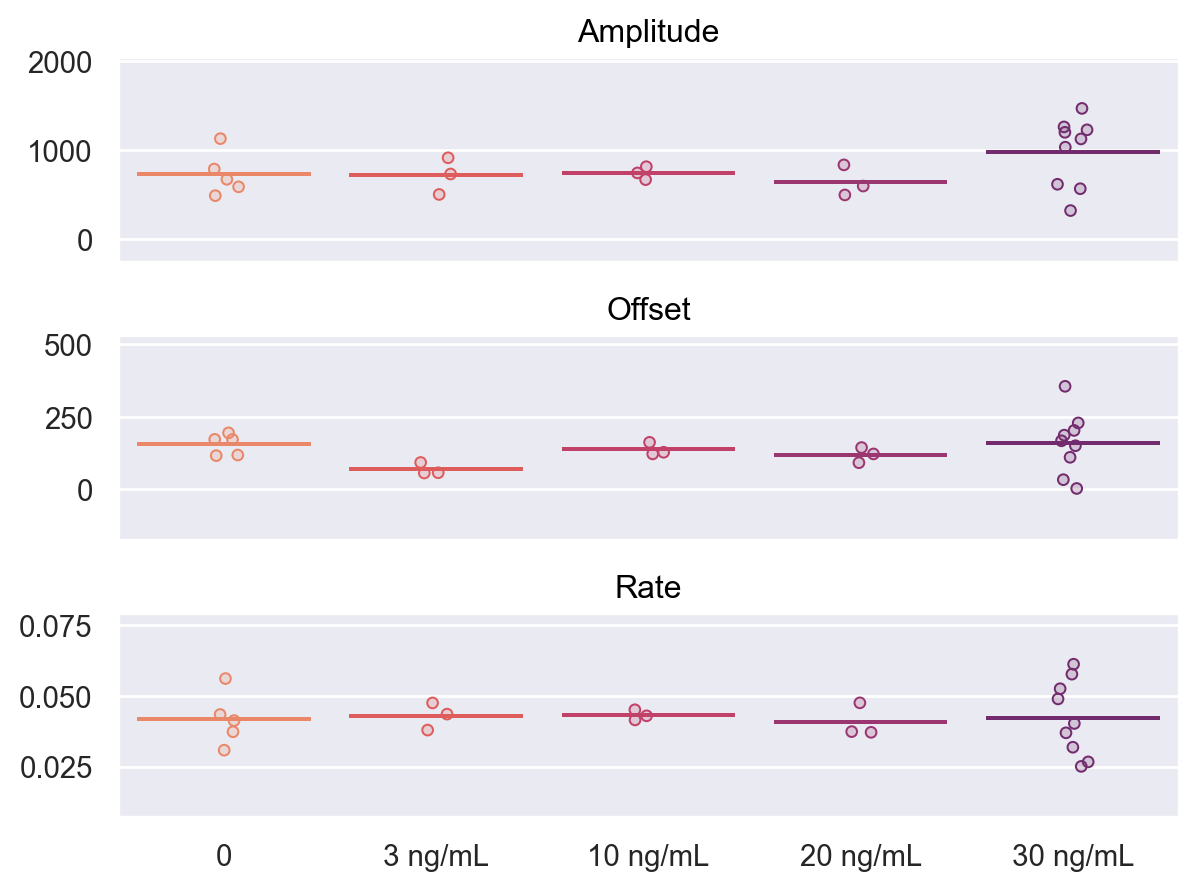

In [3]:
import seaborn.objects as so

bleaching_parameters = bleaching_fit.get_fit_parameters(param_names=['Amplitude', 'Rate', 'Offset'])

(
    so.Plot(bleaching_parameters, x='Group', y='Fitted_param', color='Group')
    .facet(row='Param_name')
    .add(so.Dots(), so.Jitter(), legend=False)
    .add(so.Dash(), so.Agg(), legend=False)
    .scale(color='flare')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="", color='')
    .theme({'axes.ymargin':0.5})
    # .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/Python/RecB_article_figures/SI_Figures/Bleaching_parameters_cipro0.svg', format='svg', bbox_inches='tight')
)

Adjust bleaching rates for exposure time

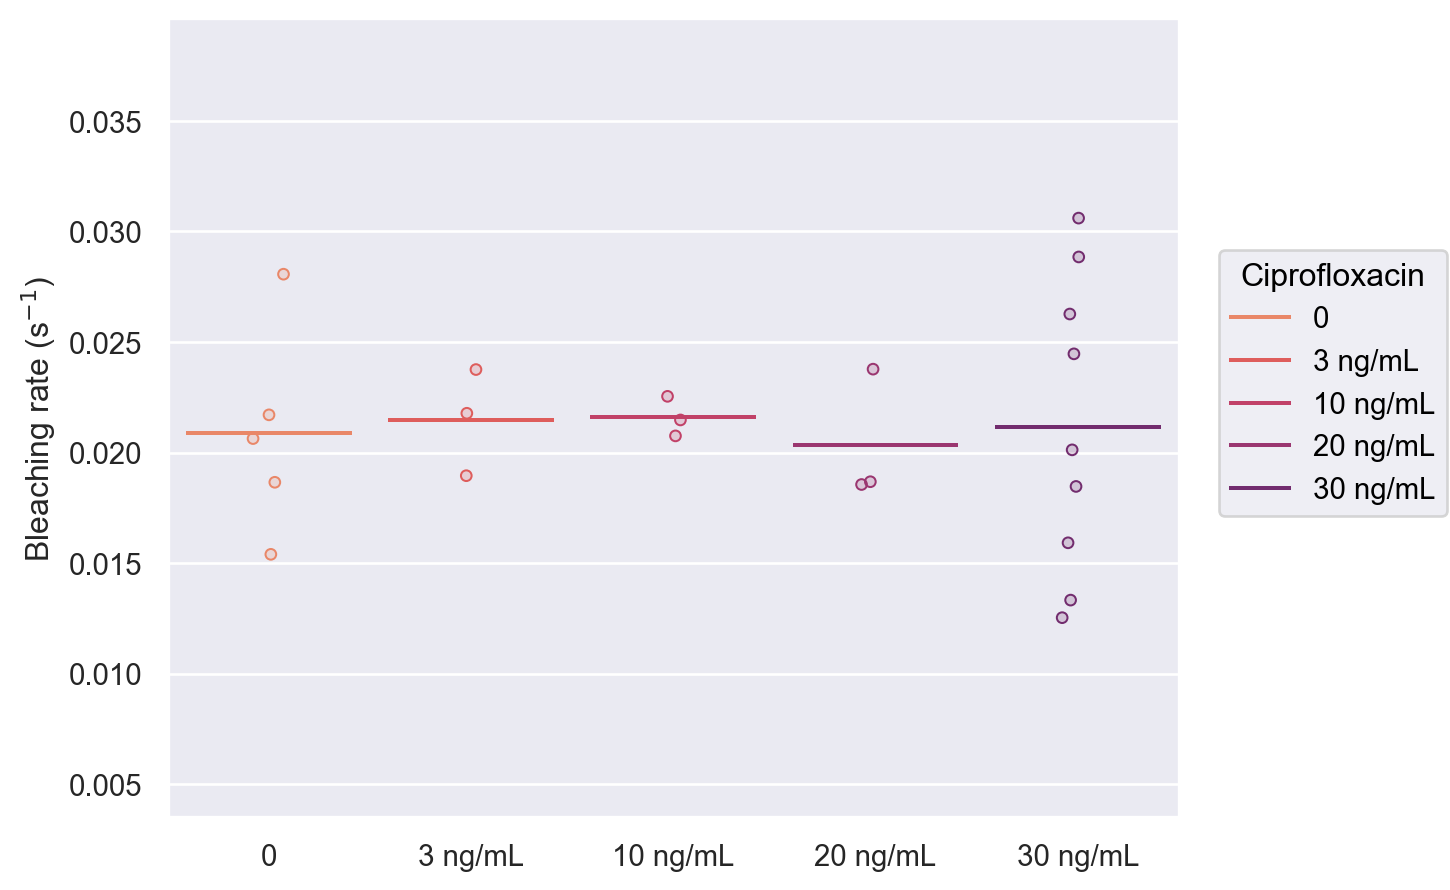

In [6]:
bleaching_rates = (bleaching_fit.get_fit_parameters(param_names=['Amplitude', 'Rate', 'Offset'])
                   .query('Param_name == "Rate"')
                   .assign(Adjusted_rate=lambda df: df.Fitted_param.div(2))
                   )

(
    so.Plot(bleaching_rates, x='Group', y='Adjusted_rate', color='Group')
    .add(so.Dash(), so.Agg())
    .add(so.Dots(), so.Jitter(), legend=False)
    .scale(color='flare')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="Bleaching rate (s$^{-1}$)", color='Ciprofloxacin')
    .theme({'axes.ymargin':0.5})
    # .save(loc='M:\\Figures\\RecB_article_figures\\2_Cipro_RecB\\RecB_lifetimes.svg', format='svg', bbox_inches='tight')
)

## RecB binding time on DNA

Fit spot lifetime to find a threshold above which a spot can be considered long-lived (based on the lifetime distribution of the short-lived spots)

In [3]:
from pyberries.data import Fit, get_histogram
from pyberries.data import get_model
import pandas as pd
import numpy as np

hist = get_histogram(data.RecB_spots, col='TrackLength', binsize=1, groupby=['Group', 'Dataset'], density=True, discrete=False, binlabels='left')                     
lifetime_fit = Fit(hist, x='TrackLength', y='proportion', model_type='biexp_decay',
                   groupby=['Group', 'Dataset'], p0=[1, 1, 0.1, 0.1])


monoexp_decay = get_model('monoexp_decay')

fit_params = lifetime_fit.get_fit_parameters(param_names=['a1', 'b1', 'a2', 'b2'])

lifetime_fit.data[['Fit_fast', 'Fit_slow', 'p_slow']] = pd.DataFrame(columns=['Fit_fast', 'Fit_slow', 'p_slow'], dtype='float64')
for ds, df in lifetime_fit.data.groupby('Dataset'):
    params = fit_params.query('Dataset == @ds')
    df = (df
          .assign(Fit_fast = lambda df: monoexp_decay(df.TrackLength, a=params.Fitted_param.iloc[0], b=params.Fitted_param.iloc[1]),
                  Fit_slow = lambda df: monoexp_decay(df.TrackLength, a=params.Fitted_param.iloc[2], b=params.Fitted_param.iloc[3]),
                  p_slow = lambda df: df.Fit_slow/(df.Fit_slow + df.Fit_fast))
          )
    lifetime_fit.data.loc[lifetime_fit.data.Dataset == ds,:] = df

Show the fits

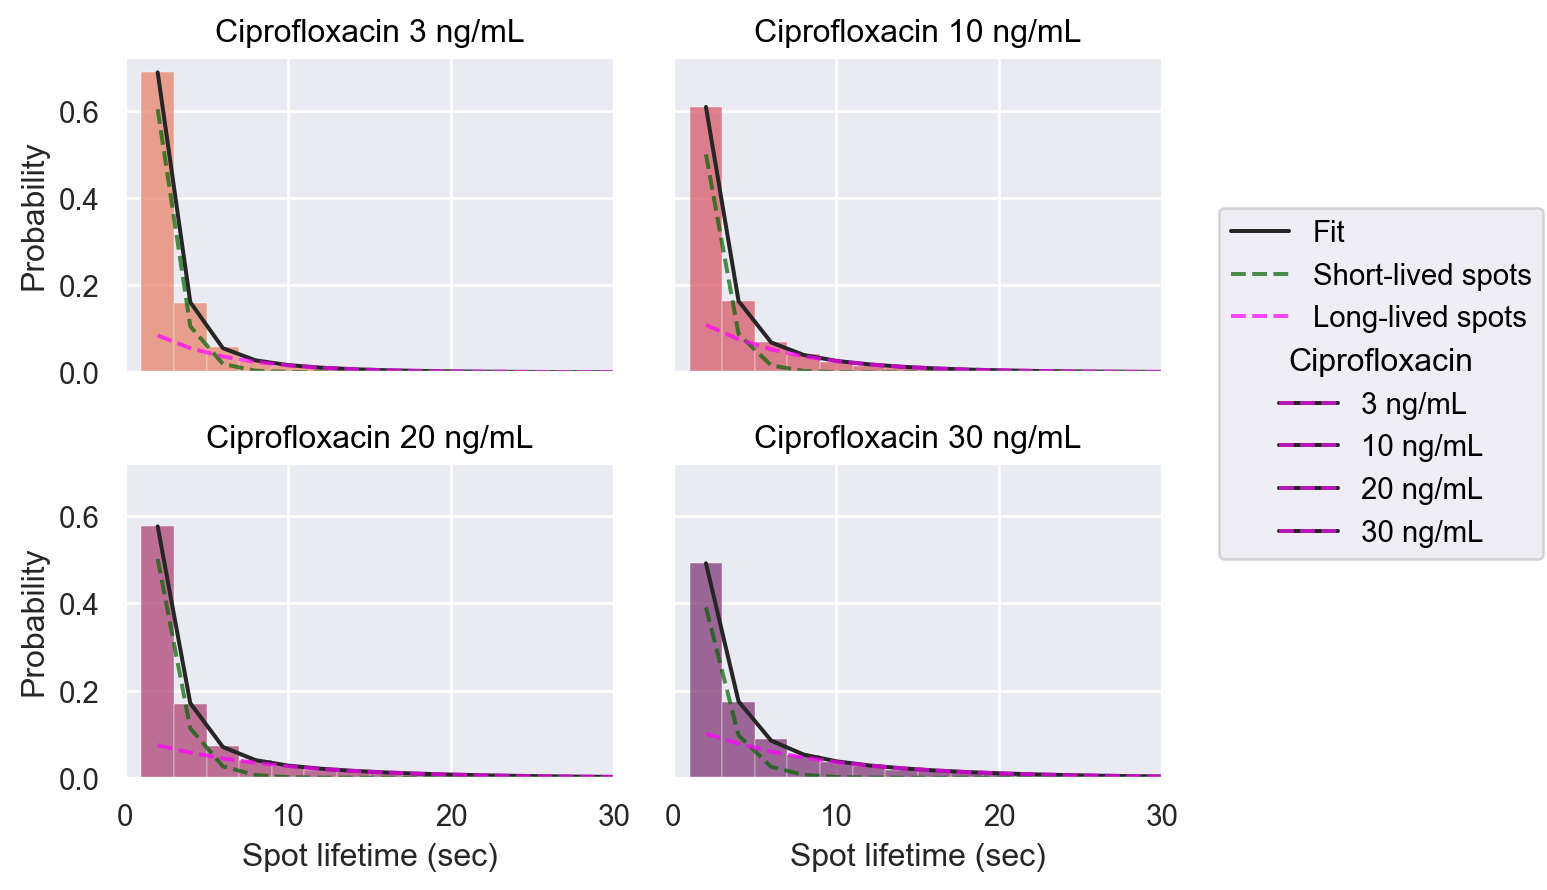

In [36]:
import seaborn.objects as so

df = (lifetime_fit
      .data
      .assign(TrackLength_s=lambda df: df.TrackLength * 2)
      .query('Group != "0"')
      )

(
    so.Plot(df, x='TrackLength_s', color='Group')
    .facet(col='Group', wrap=2)
    .add(so.Bars(), so.Agg(), y='proportion', legend=False)
    .add(so.Line(color='k'), so.Agg(), y='Fit', label='Fit')
    .add(so.Line(linestyle='--', color='darkgreen', alpha=0.7), so.Agg(), y='Fit_fast', label='Short-lived spots')
    .add(so.Line(linestyle='--', color='fuchsia', alpha=0.7), so.Agg(), y='Fit_slow', label='Long-lived spots')
    .scale(color=so.Nominal('flare'))
    .limit(x=(0, 30), y=(None, None))
    .label(x="Spot lifetime (sec)", y="Probability", color='Ciprofloxacin', title='Ciprofloxacin {}'.format)
    # .save(loc='D:\\DanielThedie\\Figures\\RecB_article_figures\\2_Cipro_RecB\\RecB_lifetimes_fits.svg', format='svg', bbox_inches='tight')
)

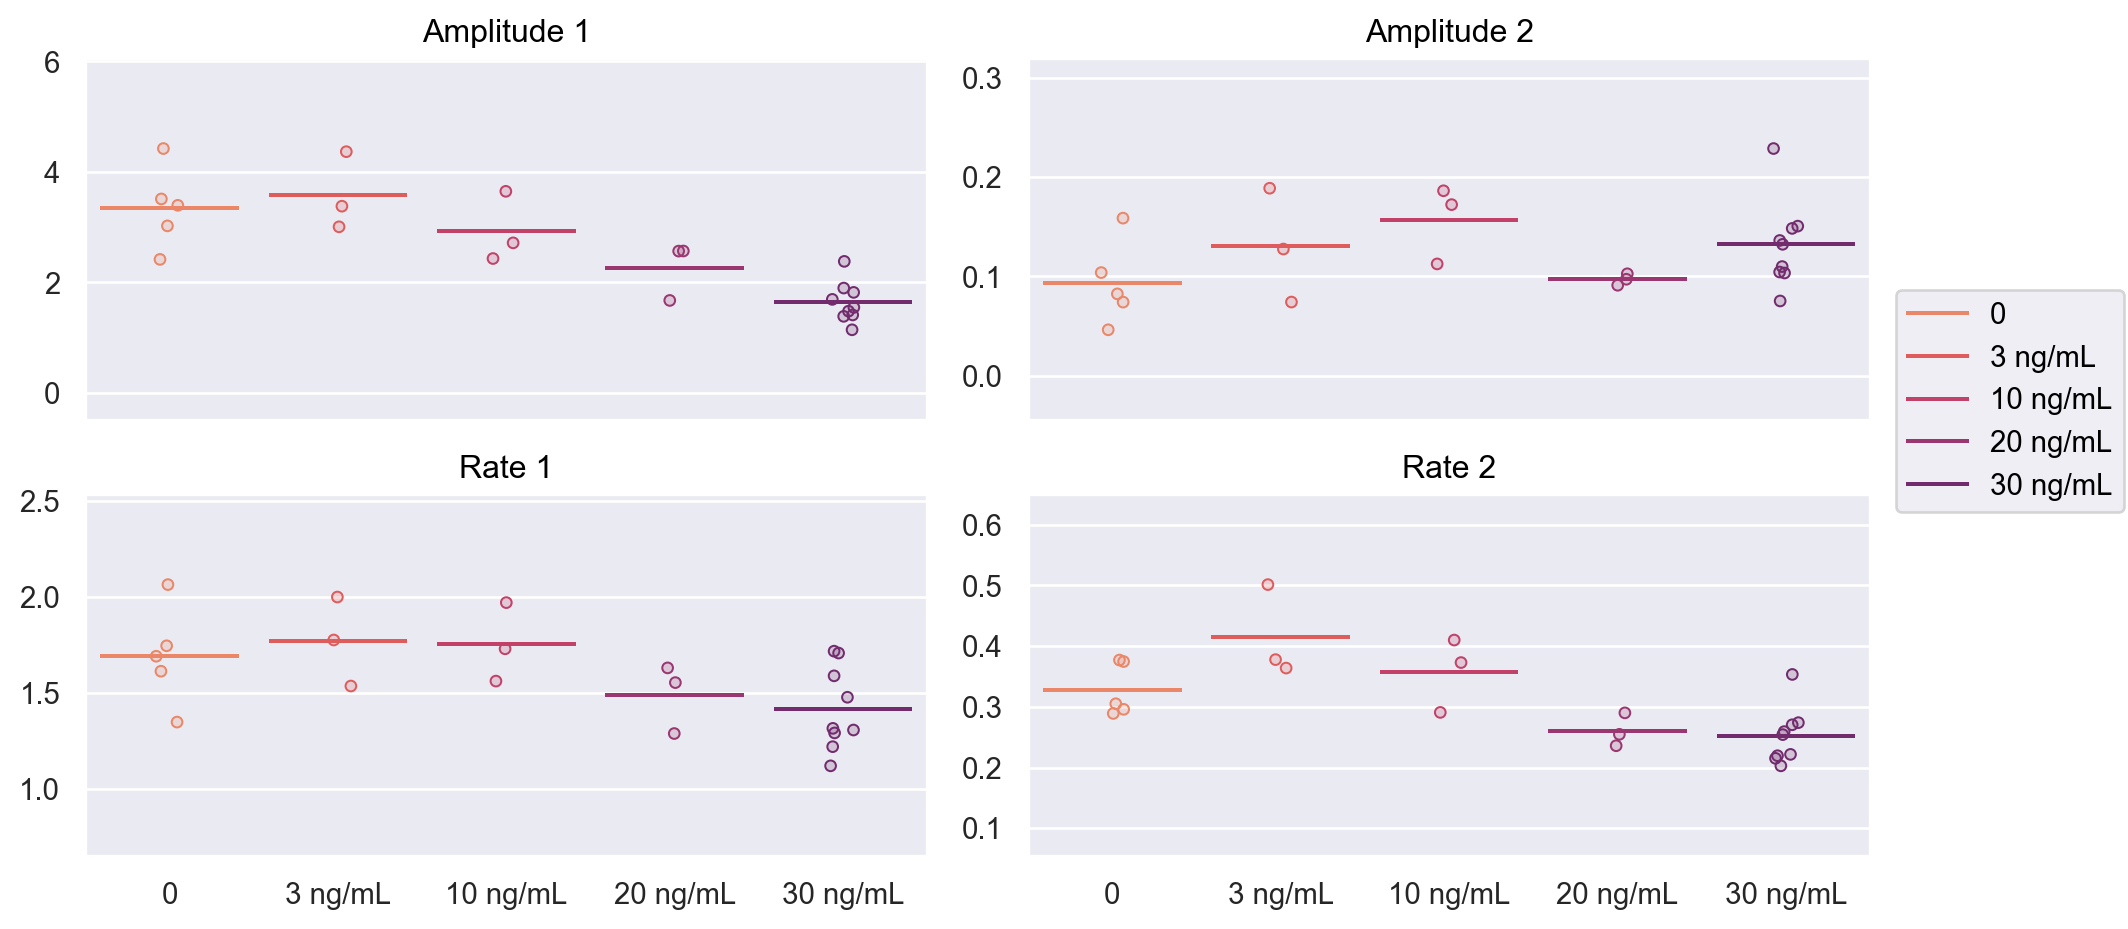

In [4]:
import seaborn.objects as so

biexp_parameters = lifetime_fit.get_fit_parameters(param_names=['Amplitude 1', 'Rate 1', 'Amplitude 2', 'Rate 2'])

(
    so.Plot(biexp_parameters, x='Group', y='Fitted_param', color='Group')
    .layout(size=(10, 5))
    .facet(col='Param_name', wrap=2)
    .add(so.Dash(), so.Agg())
    .add(so.Dots(), so.Jitter(), legend=False)
    .scale(color='flare')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="", color='')
    .theme({'axes.ymargin':0.5})
    # .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/Python/RecB_article_figures/SI_Figures/Bleaching_parameters_cipro0.svg', format='svg', bbox_inches='tight')
)

Rates (both short and long-lived spots)

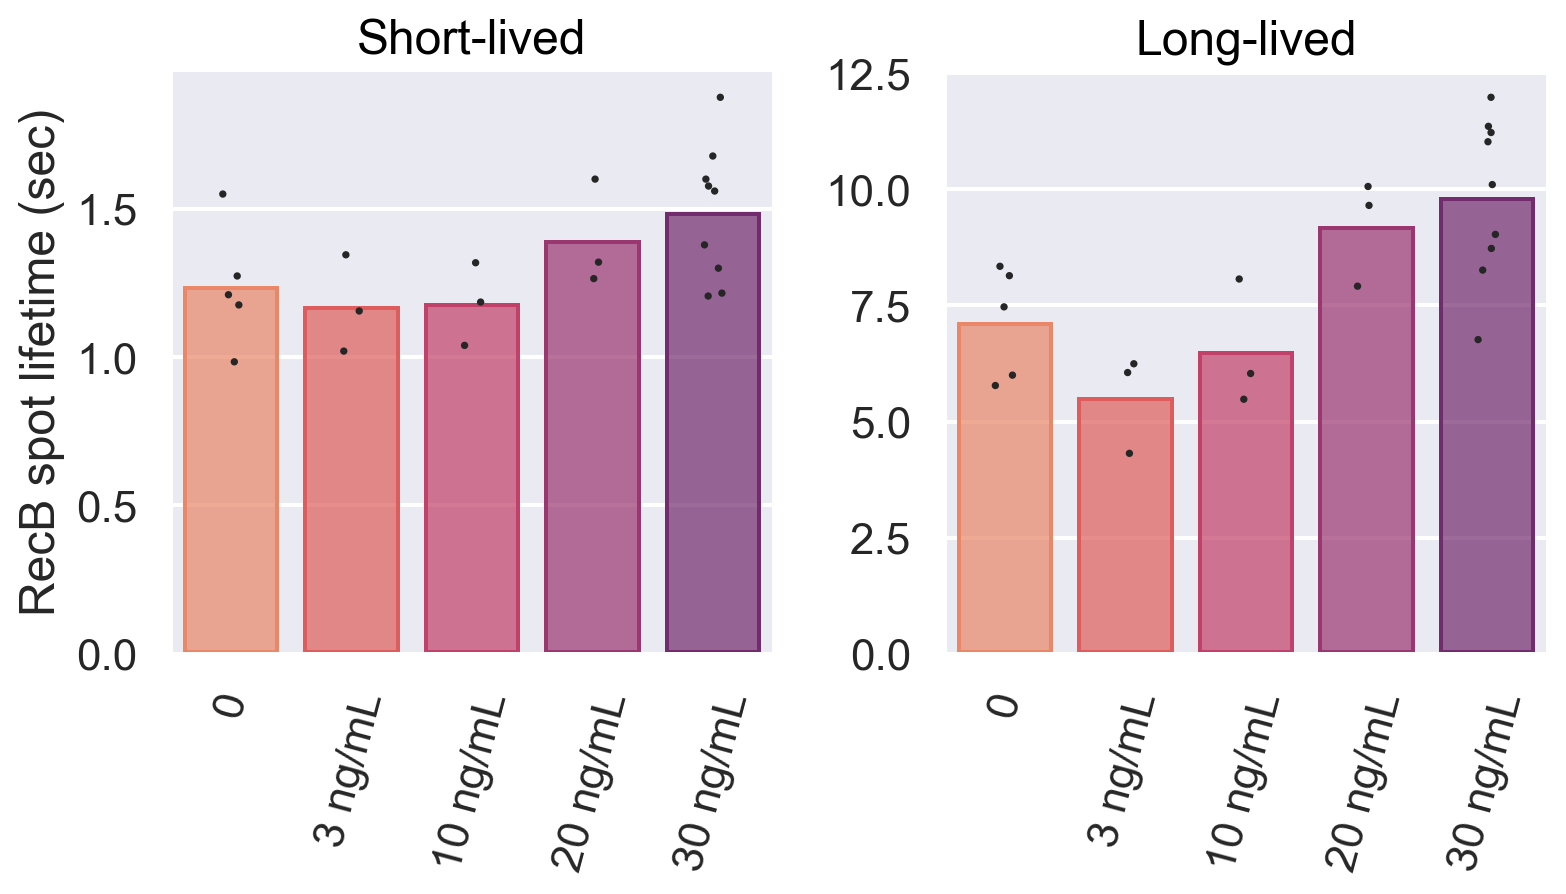

In [92]:
from seaborn import plotting_context
import numpy as np

df = (lifetime_fit.get_rates(dt=2, offset=list(bleaching_rates.Adjusted_rate))
                  .assign(Lifetime=lambda df: 1/df.Rate
                          )
                  .replace({'Fast':'Short-lived', 'Slow':'Long-lived'})
         )

p = (
    so.Plot(df, x='Group', y='Lifetime', color='Group')
    .layout(size=(8.5,5))
    .facet(col='Rate_type')
    .add(so.Bar(), so.Agg(), legend=False)
    .add(so.Dots(color='k', fillalpha=1, marker='.'), so.Jitter(), legend=False)
    .scale(color='flare')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="RecB spot lifetime (sec)", color='Ciprofloxacin')
    .theme(plotting_context('talk'))
    .plot()
)

p._figure.axes[0].xaxis.set_tick_params(rotation=75)
p._figure.axes[1].xaxis.set_tick_params(rotation=75)

# display(p)
p.save(loc='D:\\DanielThedie\\Figures\\RecB_article_figures\\2_Cipro_RecB\\RecB_lifetimes.svg', format='svg', bbox_inches='tight')

Proportion of long-lived spots

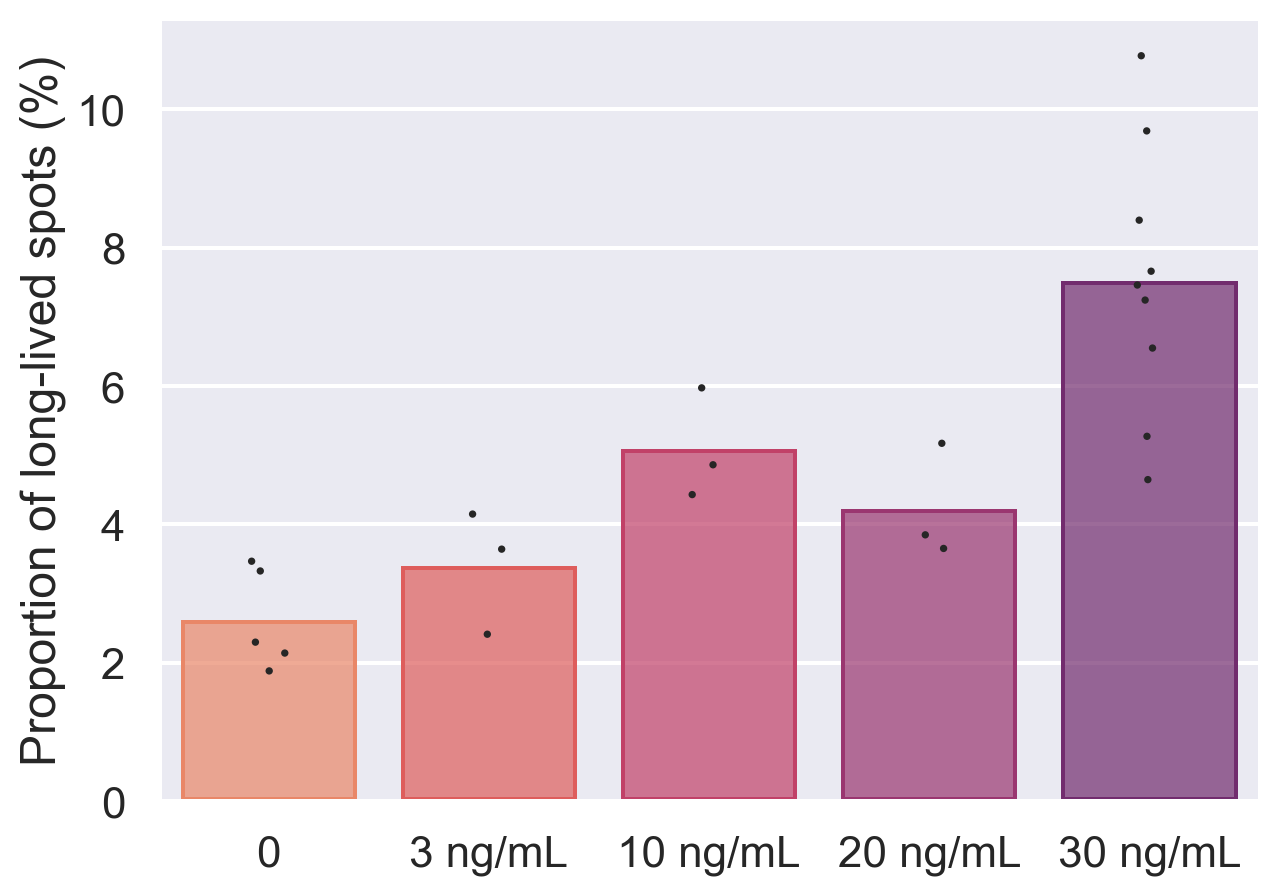

In [95]:
from seaborn import plotting_context

df = (lifetime_fit.get_rates(dt=2, offset=list(bleaching_rates.Adjusted_rate))
                  .query('Rate_type == "Slow"')
                  .assign(Lifetime=lambda df: 1/df.Rate,
                          Population=lambda df: df.Population*100
                          )
         )

(
    so.Plot(df, x='Group', y='Population', color='Group')
    .layout(size=(7,5))
    .add(so.Bar(), so.Agg(), legend=False)
    .add(so.Dots(color='k', fillalpha=1, marker='.'), so.Jitter(), legend=False)
    .scale(color='flare')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="Proportion of long-lived spots (%)", color='Ciprofloxacin')
    .theme(plotting_context('talk'))
    .save(loc='D:\\DanielThedie\\Figures\\RecB_article_figures\\2_Cipro_RecB\\Proportion_long_spots.svg', format='svg', bbox_inches='tight')
)

RecB binding lifetimes

Lifetime          
              mean       std
Group                       
0         7.145018  1.195796
10 ng/mL  6.527746  1.363073
20 ng/mL  9.209638  1.140048
3 ng/mL   5.537654  1.063256
30 ng/mL  9.829567  1.736276

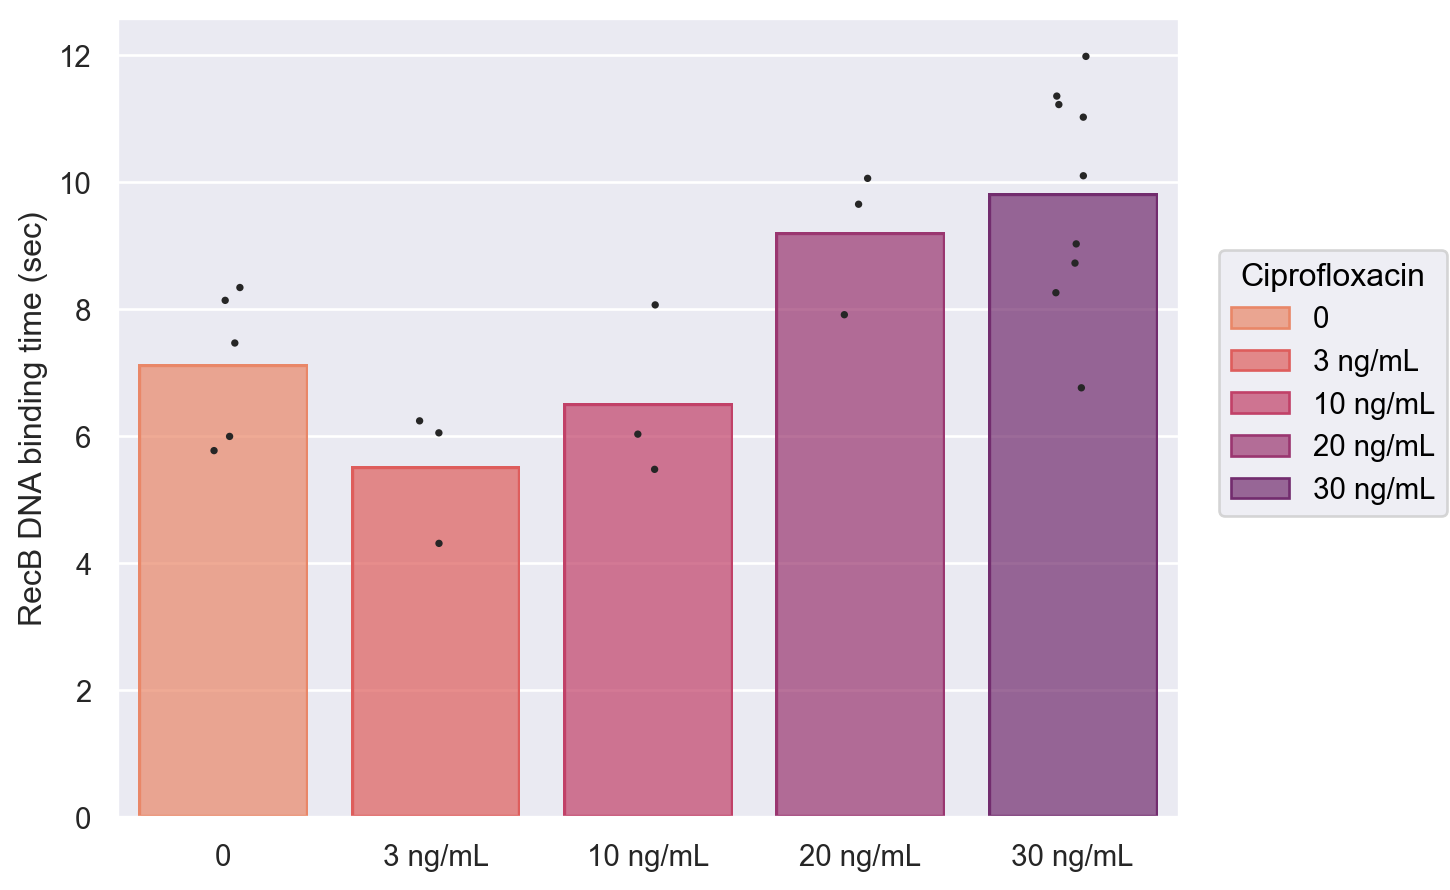

In [7]:
df = (lifetime_fit.get_rates(dt=2, offset=list(bleaching_rates.Adjusted_rate))
                  .query('Rate_type == "Slow"')
                  .assign(Lifetime=lambda df: 1/df.Rate,
                          Population=lambda df: df.Population*100
                          )
         )

display(df.groupby('Group').agg({'Lifetime':['mean', 'std']}))

(
    so.Plot(df, x='Group', y='Lifetime', color='Group')
    .add(so.Bar(), so.Agg())
    .add(so.Dots(color='k', fillalpha=1, marker='.'), so.Jitter(), legend=False)
    .scale(color='flare')
    .share(y=False)
    .limit(y=(None, None))
    .label(x="", y="RecB DNA binding time (sec)", color='Ciprofloxacin')
    # .theme({'axes.ymargin':0.5})
    # .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/RecB_lifetimes.svg', format='svg', bbox_inches='tight')
)

## Figures

### Number of RecB spots

Normalised over cell length and number of cells

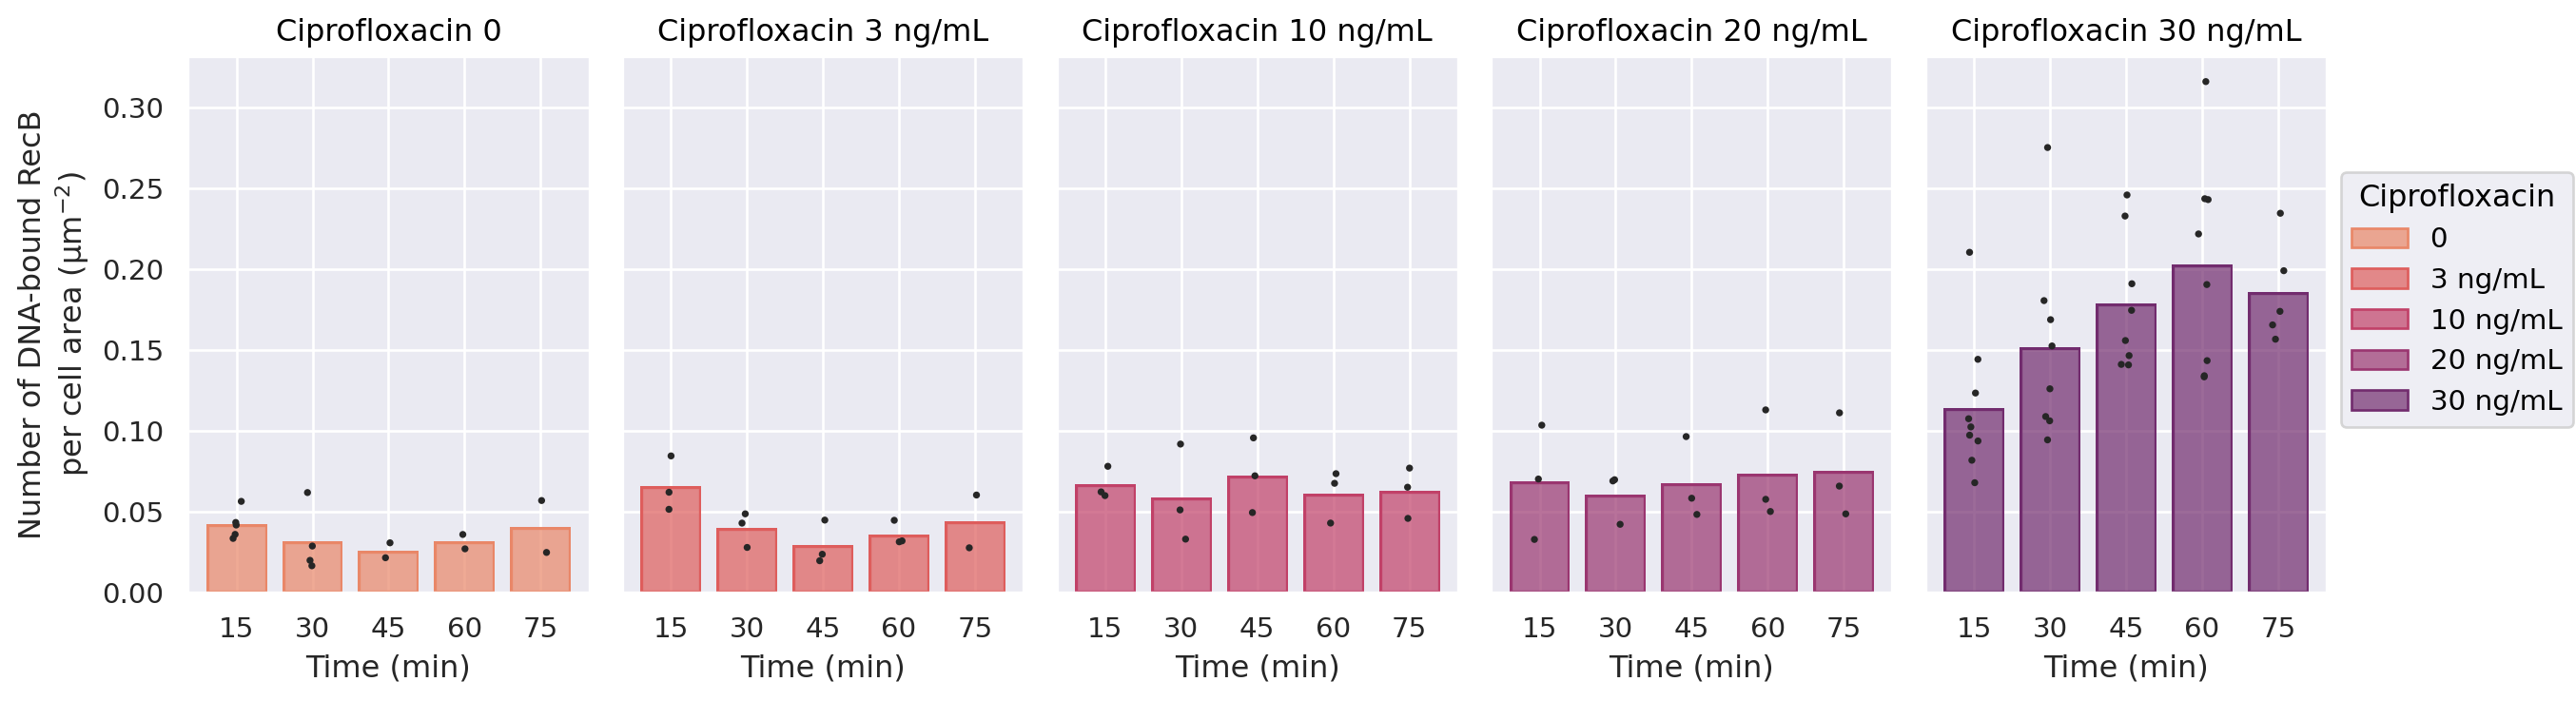

In [8]:
import seaborn.objects as so

data = data.bin_column(object_name=['Bacteria_large', 'RecB_spots'], col='Time_min', binsize=15, binlabels='left')

df = (data
      .assign(object_name='RecB_spots',
              long_spot=lambda df: df.TrackLength.ge(5).replace({True:'Long', False:'Short'})
              )
      .get_parent_indices(object_name='RecB_spots')
      .add_from_parent(object_name='RecB_spots', col='Area')
      .RecB_spots
      .groupby(by=['Group', 'Dataset', 'Time_min_bin', 'long_spot', 'ParentIndices'])
      .agg({'Indices': 'count', 'Area': 'mean'})
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .assign(norm_count=lambda df: df.SpotCount / df.Area)
      .groupby(by=['Group', 'Dataset', 'Time_min_bin', 'long_spot'])
      .agg({'norm_count': 'sum'})
      .reset_index()
      .merge(data.Bacteria_large.groupby(['Dataset', 'Time_min_bin'])['Position'].count().reset_index().rename(columns={'Position':'nCells'}),
             how='left',
             on=['Dataset', 'Time_min_bin'],
             suffixes=('_old', None))
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(nCells=lambda df: df.nCells / 50,  # To account for the fact that 1 cell appears in 50 images of the timelapse
              norm_count=lambda df: df.norm_count / df.nCells
              )
      .query('Time_min_bin < 90 and long_spot == "Long"')
      )

(
 so.Plot(df, x='Time_min_bin', y='norm_count', color='Group')
 .layout(size=(13, 4))
 .facet(col='Group', order=['0', '3 ng/mL', '10 ng/mL', '20 ng/mL', '30 ng/mL'])
 .add(so.Bar(), so.Agg())
 .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), legend=False)
 .scale(alpha=so.Nominal(), color=so.Nominal('flare', order=['0', '3 ng/mL', '10 ng/mL', '20 ng/mL', '30 ng/mL']), x=so.Continuous().tick(every=15))
 .share(y=True)
 .limit(x=(None, None), y=(None, None))
 .label(x="Time (min)", y="Number of DNA-bound RecB\nper cell area (µm$^{-2}$)", title='Ciprofloxacin {}'.format, color='Ciprofloxacin')
 .save(loc='/media/daniel/HDD Daniel/DanielThedie/Figures/RecB_article_figures/2_Cipro_RecB/Cipro_num_spots.svg', format='svg', bbox_inches='tight')
 )

Without splitting long/short spots:

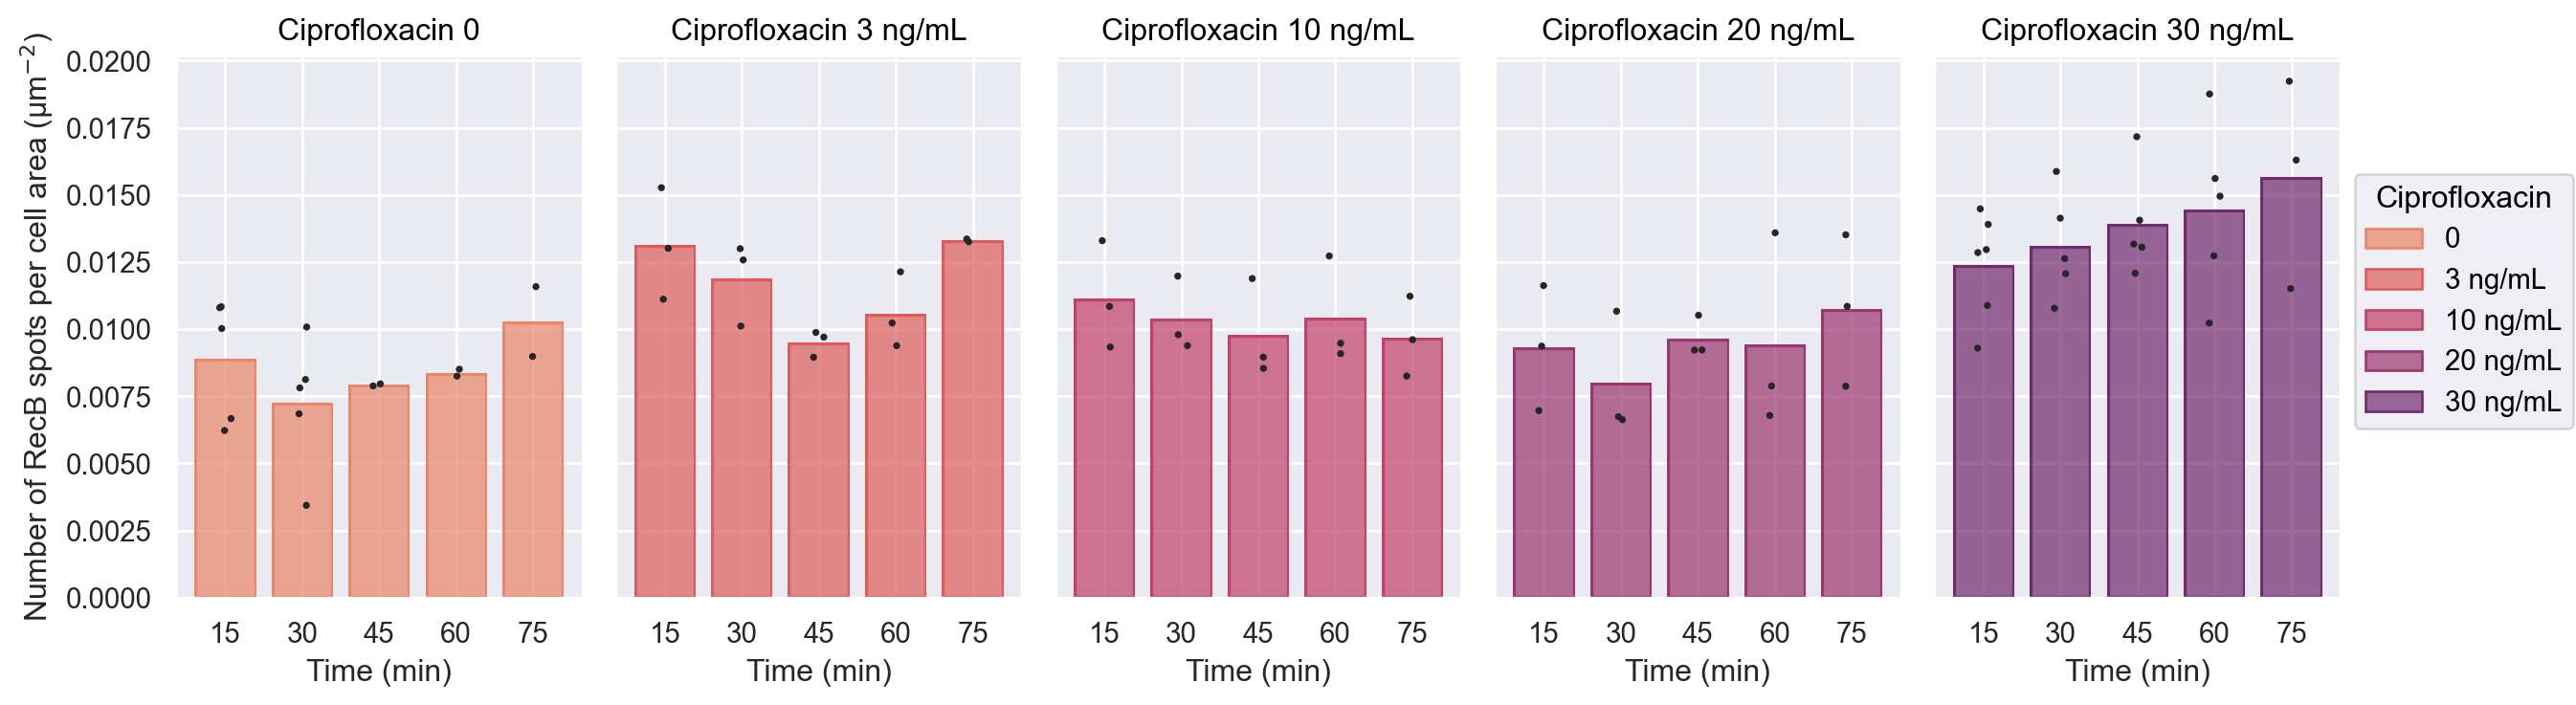

In [4]:
import seaborn.objects as so

data = data.bin_column(object_name=['Bacteria_large', 'RecB_spots'], col='Time_min', binsize=15, binlabels='left')

df = (data
      .get_parent_indices(object_name='RecB_spots')
      .add_from_parent(object_name='RecB_spots', col='Area')
      .RecB_spots
      .groupby(by=['Group', 'Dataset', 'Time_min_bin', 'ParentIndices']) # Group per cell
      .agg({'Indices': 'count', 'Area': 'mean'}) # Count number of spots (trackheads only, so we're not biased by track length) per cell
      .rename(columns={'Indices':'SpotCount'})
      .reset_index()
      .assign(norm_count=lambda df: df.SpotCount / df.Area) # Normalise spot count by cell Area
      .groupby(by=['Group', 'Dataset', 'Time_min_bin'])
      .agg({'norm_count': 'sum'}) # Sum all spots for each bin (can't do a mean, otherwise it would exclude cells with 0 spots)
      .reset_index()
      .merge(data.Bacteria_large.groupby(['Dataset', 'Time_min_bin'])['Position'].count().reset_index().rename(columns={'Position':'nCells'}),
             how='left',
             on=['Dataset', 'Time_min_bin'],
             suffixes=('_old', None)) # Add the number of cells for each bin (including those that have 0 spots)
      .transform(lambda df: df.loc[:, ~df.columns.str.contains('_old')])
      .assign(norm_count=lambda df: df.norm_count / df.nCells) # Divide the total count by the number of cells in the bin
      .query('Time_min_bin < 90')
      )

(
 so.Plot(df, x='Time_min_bin', y='norm_count', color='Group')
 .layout(size=(13, 4))
 .facet(col='Group', order=['0', '3 ng/mL', '10 ng/mL', '20 ng/mL', '30 ng/mL'])
 .add(so.Bar(), so.Agg())
 .add(so.Dots(color='k', marker='.', fillalpha=1), so.Jitter(), legend=False)
 .scale(color=so.Nominal('flare', order=['0', '3 ng/mL', '10 ng/mL', '20 ng/mL', '30 ng/mL']), x=so.Continuous().tick(every=15))
 .share(y=True)
 .limit(x=(None, None), y=(None, None))
 .label(x="Time (min)", y="Number of RecB spots per cell area (µm$^{-2}$)", title='Ciprofloxacin {}'.format, color='Ciprofloxacin')
#  .save(loc='/media/daniel/HDD Daniel/Daniel Thédié/RecB_counting_long_short.svg', format='svg', bbox_inches='tight')
 )

Inspect individual datasets:

array(['230118_DT23', '230720_1', '230720_2', '230726_cipro30',
       '230824_1', '230829_1', '230201_DT23', '230504_2sec',
       '230718_2sec'], dtype=object)

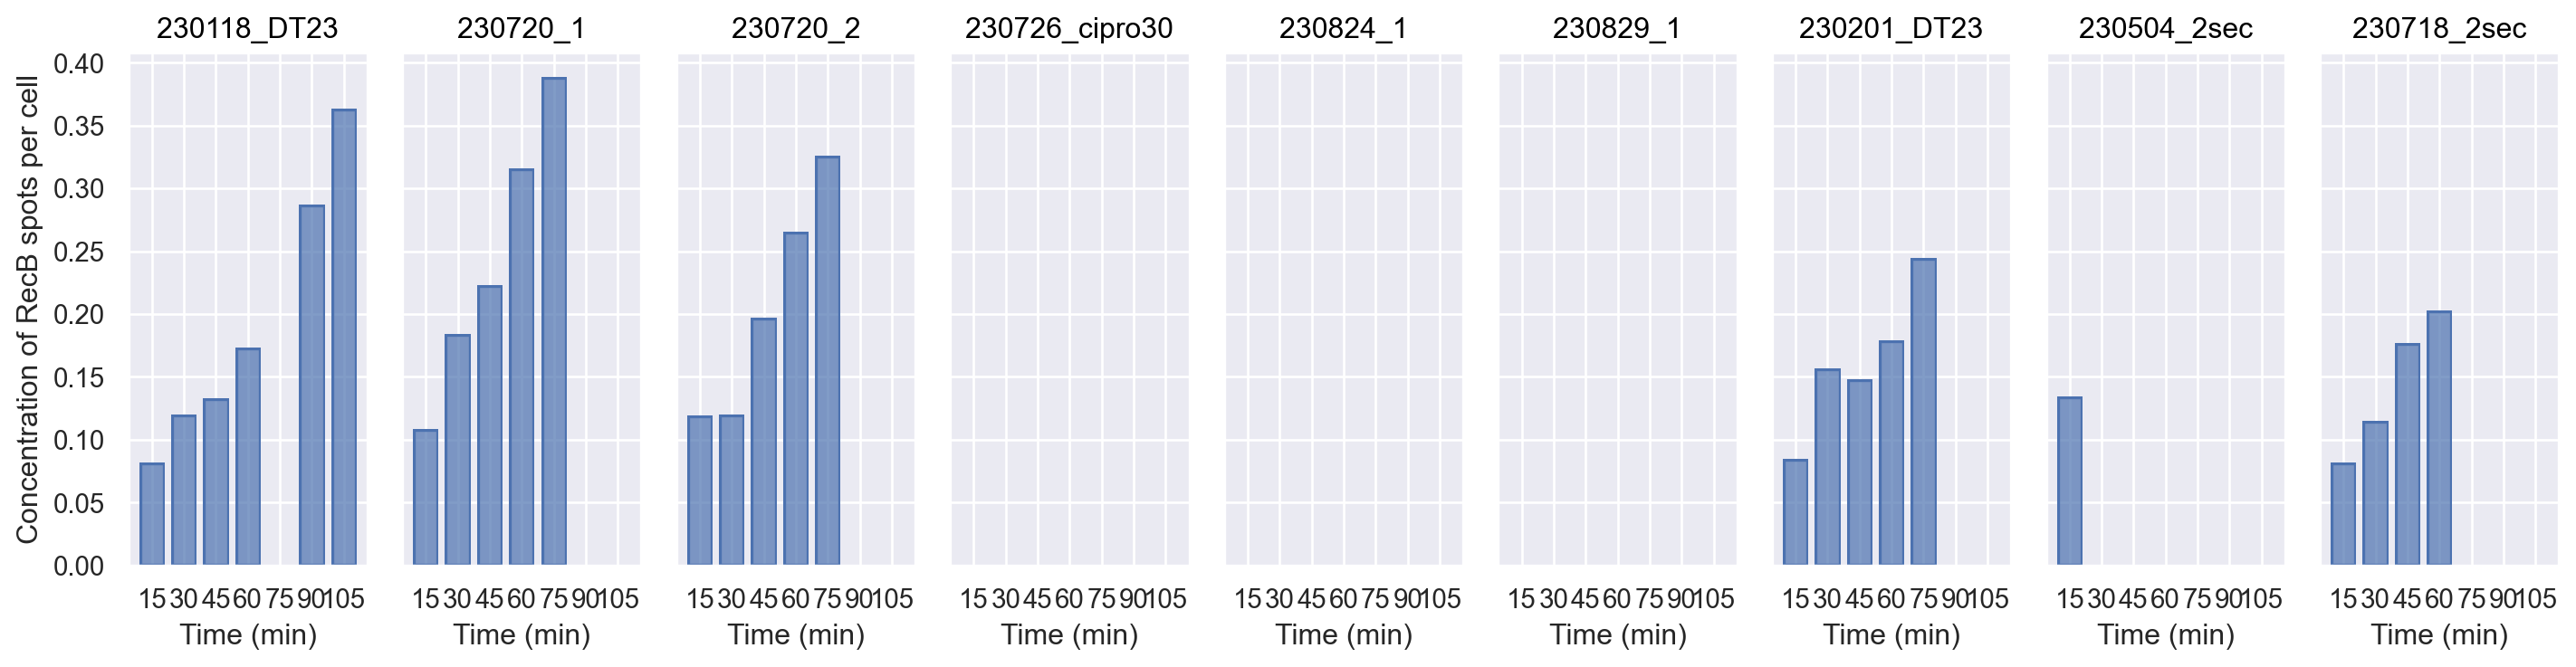

In [34]:
df = data.Bacteria_large.query('Group == "30 ng/mL"')

display(df.Dataset.unique())

(
 so.Plot(df, x='Time_min_bin', y='RecBSpotCount')
 .layout(size=(15, 4))
 .facet(col='Dataset')
 .add(so.Bar(), so.Agg())
 .scale(alpha=so.Nominal(), x=so.Continuous().tick(every=15))
 .limit(x=(None, None), y=(None, None))
 .label(x="Time (min)", y="Concentration of RecB spots per cell")
 )

### RecB spot position

c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
c:\Users\dthedie\Miniconda3\envs\PyBerries_dev\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
 

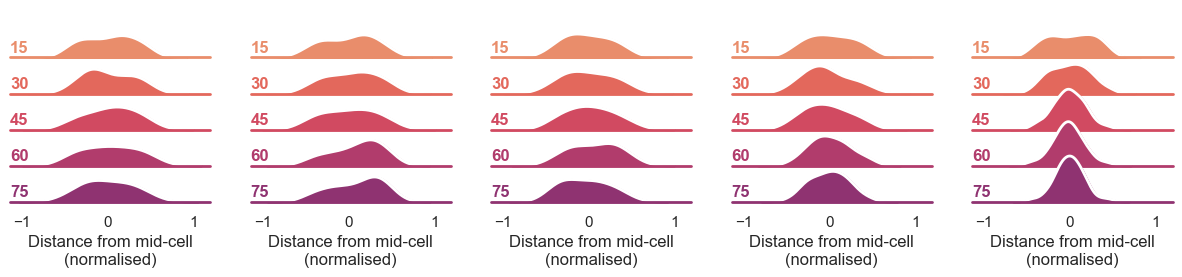

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

df = (data
      .assign(object_name='RecB_spots', 
              midCellDist=lambda df: df.SpineCurvilinearCoord / df.SpineLength - 0.5,
              )
      .bin_column(object_name='RecB_spots', col='Time_min', binsize=15, binlabels='left')
      .set_type(object_name='RecB_spots', type_dict={'Time_min_bin':'int'})
      .RecB_spots
      .query('Time_min_bin < 90 and TrackLength >= 5')
      )

# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="Time_min_bin", col='Group', hue="Time_min_bin", aspect=6, height=.5, palette=sns.color_palette('flare'))

# Draw the densities in a few steps
g.map(sns.kdeplot, "midCellDist",
      bw_adjust=1.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "midCellDist", clip_on=False, color="w", lw=2, bw_adjust=1.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "midCellDist")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="", xlabel='Distance from mid-cell\n(normalised)')
g.despine(bottom=True, left=True)

plt.savefig(fname='D:\\DanielThedie\\Figures\\RecB_article_figures\\2_Cipro_RecB\\RecB_position.svg', format='svg', bbox_inches='tight')